### Brightness Distributions
This code calculates and plots the distribution of satellite brightness over the night sky, as seen by a ground-based observer. Several models are included.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import lumos.conversions
import lumos.brdf.library
import lumos.calculator
import lumos.plot
from starlink import satellitemodels
from lumos.brdf.library import BINOMIAL, LAMBERTIAN, PHONG
from lumos.geometry import Surface
from analysis import calculator
import matplotlib
import matplotlib.pyplot as plt



# Setting up the satellite model surfaces and earth_brdf.
surfaces = satellitemodels.get_surfaces()
earth_brdf = lumos.brdf.library.PHONG(Kd = 0.2, Ks = 0.2, n=300)


# Solar array BRDF parameters
B = np.array([[0.534, -20.409]])
C = np.array([[-527.765, 1000., -676.579, 430.596, -175.806, 57.879]])
lab_solar_array_brdf = BINOMIAL(B, C, d=3.0, l1=-3)

# Define solar array areas and their power equivalents
solar_array_configs = [
    (104.96 * 4, "~100 kW"),
    (104.96 * 5, "~125 kW"),
    (104.96 * 6, "~150 kW"),
    (104.96 * 7, "~175 kW"),
    (104.96 * 8, "~200 kW")
]


/Users/nayanjangid/Starlink_data center
Using interpolated chassis


In [2]:
satellite_height = 550 * 1000

altitudes = np.linspace(0, 90, 45)
azimuths = np.linspace(0, 360, 90)
altitudes, azimuths = np.meshgrid(altitudes, azimuths)

sun_azimuth = 90

In [3]:
# The following functions were made by Forrest Fankhauser. I have made minor changes to them
# and reimplimented them here.

def colorbar(cax, levels):
    cmap = matplotlib.colormaps['plasma_r']
    norm = matplotlib.colors.Normalize(levels[0], levels[1])
    cb = plt.colorbar(matplotlib.cm.ScalarMappable(
        norm=norm, cmap=cmap), cax=cax, extend='both')
    cb.set_ticks(np.arange(levels[0], levels[1] + 1, 3))   # 3,4,5,...,10

    cax.set_aspect(2)


def plot_compass(ax):
    ax.arrow(0, 0, 0, 0.75, width=0.05, color="black",
             head_length=0.2, head_width=0.2)
    ax.arrow(0, 0, -0.75, 0, width=0.05, color="black",
             head_length=0.2, head_width=0.2)
    ax.scatter([0], [0], s=30, c="black", zorder=1)
    ax.annotate("N", (0, 1.15), horizontalalignment='center',
                verticalalignment='center', fontsize=14, annotation_clip=False,
                fontweight='bold')
    ax.annotate("E", (-1.15, 0), horizontalalignment='center',
                verticalalignment='center', fontsize=14, annotation_clip=False,
                fontweight='bold')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim((-1.5, 0.5))
    ax.set_ylim((-0.5, 1.5))
    ax.set_frame_on(False)
    ax.set_aspect("equal")


def contour_observer_frame(
        ax,
        altitudes,
        azimuths,
        values,
        levels=None,
        cmap='plasma'
):
    """
    Creates contour plot in observer frame

    :param ax: Matplotlib axis for plotting on
    :type ax: :class:`matplotlib.pyplot.axes`
    :param altitudes: Altitudes in HCS frame (degrees)
    :type altitudes: :class:`np.ndarray`
    :param azimuths: Azimuths in HCS frame (degrees)
    :type azimuths: :class:`np.ndarray`
    :param values: Values to plot
    :type values: :class:`np.ndarray`
    :param levels: Minimum and maximum value to plot
    :type levels: tuple, optional
    :param cmap: Matplotlib colormap to use
    :type cmap: str
    """

    if levels is None:
        levels = (4, 10)

    ax.contourf(
        np.deg2rad(azimuths),
        90 - altitudes,
        values,
        cmap=matplotlib.colormaps[cmap],
        norm=matplotlib.colors.Normalize(levels[0], levels[1]),
        levels=np.arange(levels[0], levels[1] + 2, 0.25),
        extend='both'
    )

    ax.set_rmax(90)
    ax.set_yticklabels([])
    ax.set_theta_zero_location('N')
    ax.set_rticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])
    ax.set_rlabel_position(-22.5)
    ax.grid(True)


def brightness_summary_observer_frame(
        sat_height, sun_altitudes, sun_azimuths,
        include_sun=True, include_earthshine=False,
        earth_panel_density=151, earth_brdf=earth_brdf,
        levels=(4, 10), name=None):
    if name is None:
        name = f"Starlink data center at {sat_height/1000:.0f} km elevation"

    N_frames = len(sun_altitudes)

    with plt.style.context("fast"):
        fig = plt.figure(figsize=(6.4 * 2, 3.2))
        fig.suptitle(name)

        cax = fig.add_axes([0, 0.25, 0.15, 0.3])

        h = 0.8
        w = h * 6 / 32

        ax1 = fig.add_axes([0.5 - w / 2 - 2 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax2 = fig.add_axes([0.5 - w / 2 - 1 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax3 = fig.add_axes([0.5 - w / 2 + 0 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax4 = fig.add_axes([0.5 - w / 2 + 1 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax5 = fig.add_axes([0.5 - w / 2 + 2 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax6 = fig.add_axes([0.85, 0.05, 0.45 * w, 0.45 * h])

        axs = (ax1, ax2, ax3, ax4, ax5)

        plot_compass(ax6)

        sat_altitudes, sat_azimuths = \
            np.meshgrid(
                np.arange(0, 91.0, 1),
                np.arange(0, 361.0, 1))

        sat_altitudes = sat_altitudes.flatten()
        sat_azimuths = sat_azimuths.flatten()

        for ax, sun_altitude, sun_azimuth in zip(axs, sun_altitudes, sun_azimuths):
            sat_altitudes, sat_azimuths = \
                np.meshgrid(
                    np.arange(0, 91.0, 1),
                    np.arange(0, 361.0, 1))

            sat_altitudes = sat_altitudes.flatten()
            sat_azimuths = sat_azimuths.flatten()
            calculated_intensities_reg = calculator.get_intensity_observer_frame(
                surfaces,
                np.ones(len(sat_altitudes)) * sat_height,
                sat_altitudes,
                sat_azimuths,
                sun_altitude,
                sun_azimuth,
                include_sun=True,
                include_earthshine=False,
                earth_panel_density=151,
                earth_brdf=earth_brdf
            )

            ab_magnitude = lumos.conversions.intensity_to_ab_mag(calculated_intensities_reg)
            print(ab_magnitude.mean())

            sat_altitudes, sat_azimuths = \
                np.meshgrid(
                    np.arange(0, 91.0, 1),
                    np.arange(0, 361.0, 1))

            ab_magnitude = ab_magnitude.reshape(sat_azimuths.shape)
            # Plots intensity
            contour_observer_frame(
                ax, sat_altitudes, sat_azimuths, ab_magnitude, levels, cmap="plasma_r")

            ax.set_xticklabels(["", "", "", ""])
            ax.set_title(
                f"Sun Alt. = {sun_altitude:0.0f}°\nSun Az. = {sun_azimuth:0.0f}°")
            ax.grid(linewidth=0.5, alpha=0.25)

            ax.plot([np.deg2rad(sun_azimuth)], [101],
                    marker='$\u2600$',
                    markersize=10,
                    color="orange",
                    clip_on=False)

        colorbar(cax, levels=levels)
        cax.tick_params(labelsize=14)
        cax.set_ylabel("AB Magnitude", fontsize=16)
        cax.invert_yaxis()
        cax.yaxis.set_label_position("left")

        plt.show()

This is for instantaneous power output of solar panel from ~100 - 200 kW
Using interpolated chassis

Generating plots for ~100 kW (Area: 419.84 m²)
6.158260034467611
6.287054863311743
6.675412697373021
7.736673739379829
10.555252832861656


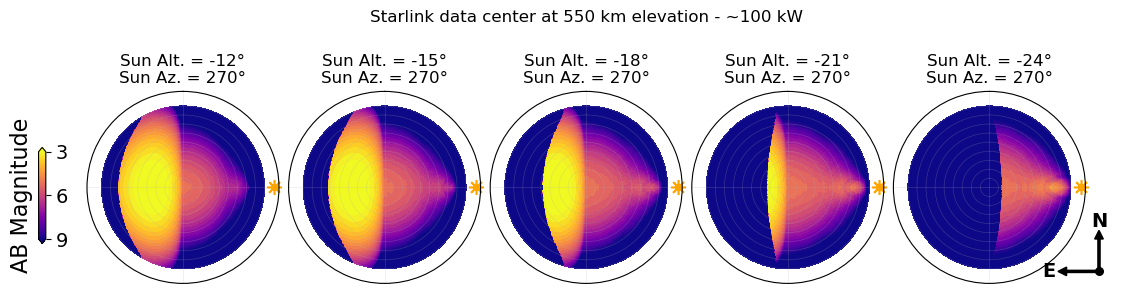

7.275414860546032
7.298808549982054
7.382694435386423
7.563692462906359
7.91120605570781


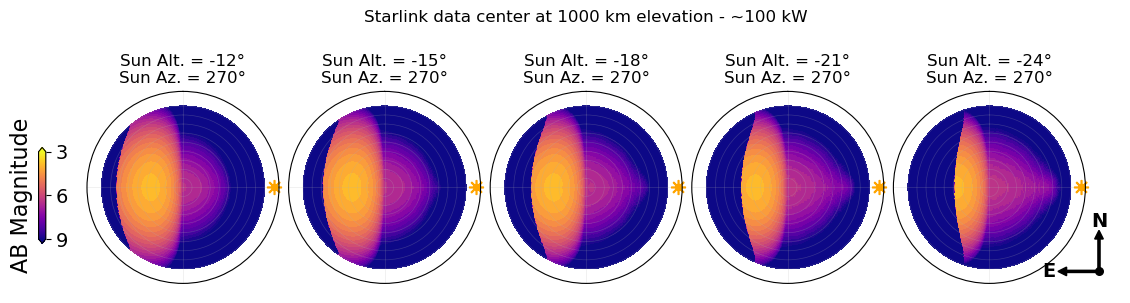

7.9407504072902935
8.002710090041623
8.06099273945896
8.146440761295478
8.282178679169524


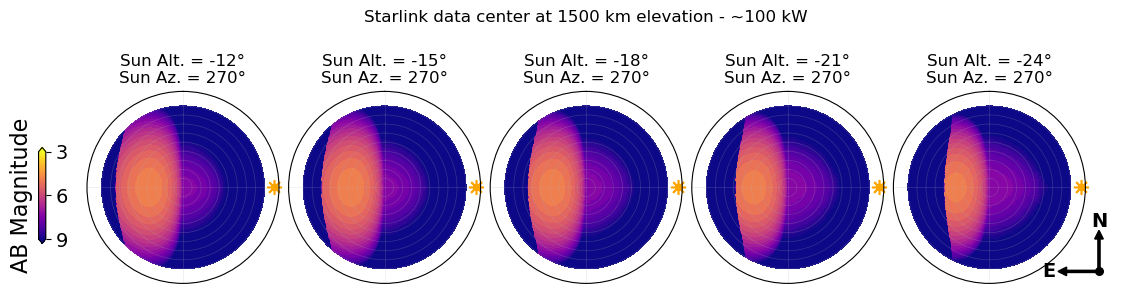

8.371917740347188
8.44714764964031
8.523256831443982
8.604118246886467
8.69549140486381


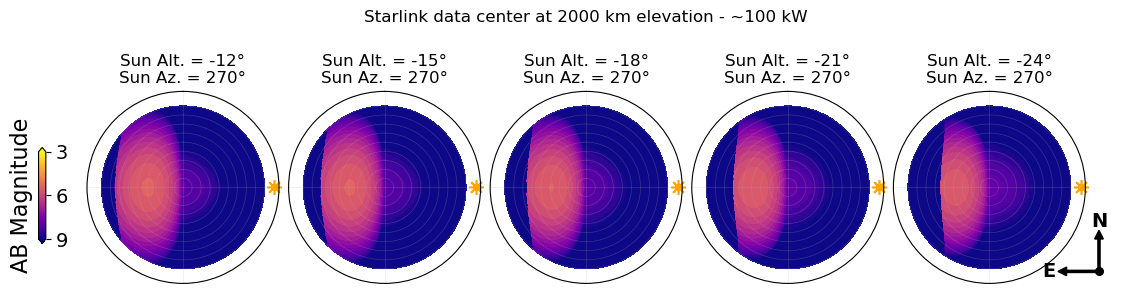

Using interpolated chassis

Generating plots for ~125 kW (Area: 524.80 m²)
6.066304630469392
6.203747487280797
6.606920009536485
7.698811056270234
10.555252832861656


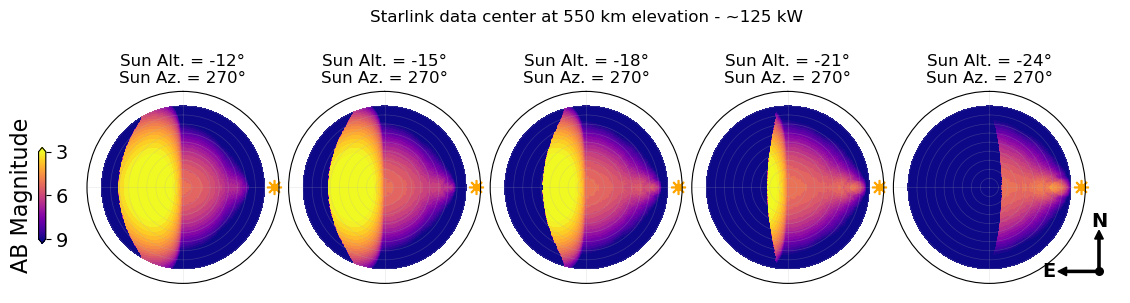

7.182769142286149
7.211725109293537
7.302921391940987
7.493951541021274
7.856036186198777


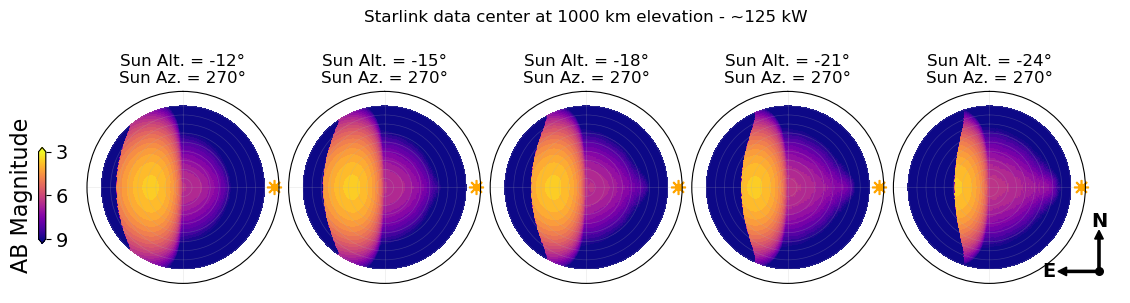

7.849153725823705
7.915887265514494
7.979897569912864
8.072508538485595
8.217174268232636


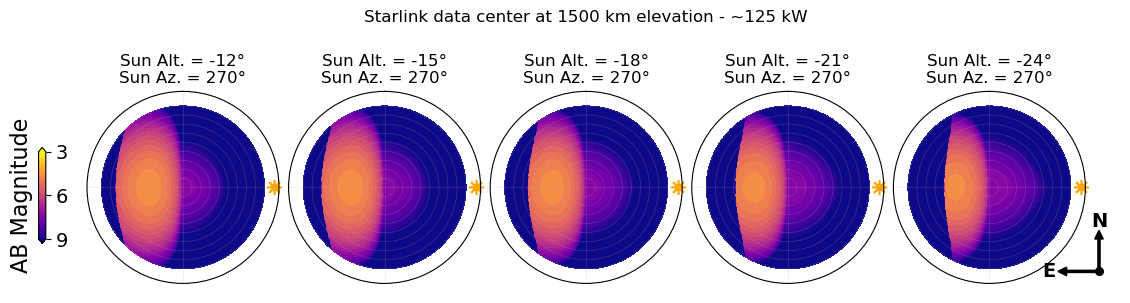

8.28175378001676
8.36148455839103
8.442804445299949
8.529851195997573
8.628496409418577


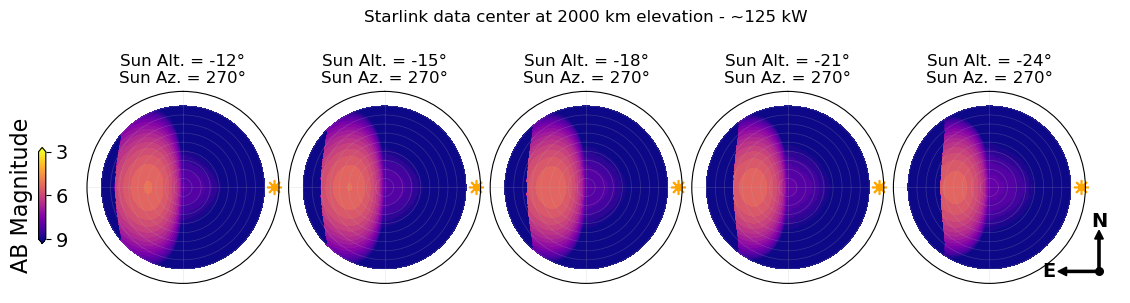

Using interpolated chassis

Generating plots for ~150 kW (Area: 629.76 m²)
5.989744674451628
6.134226089252762
6.549516035121394
7.666630159891677
10.555252832861656


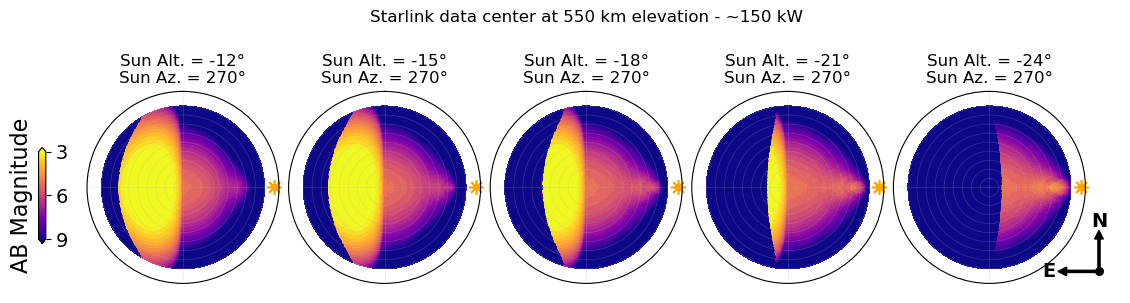

7.1055058407356135
7.1389698185922486
7.236115215510693
7.435339746090251
7.8093830639261865


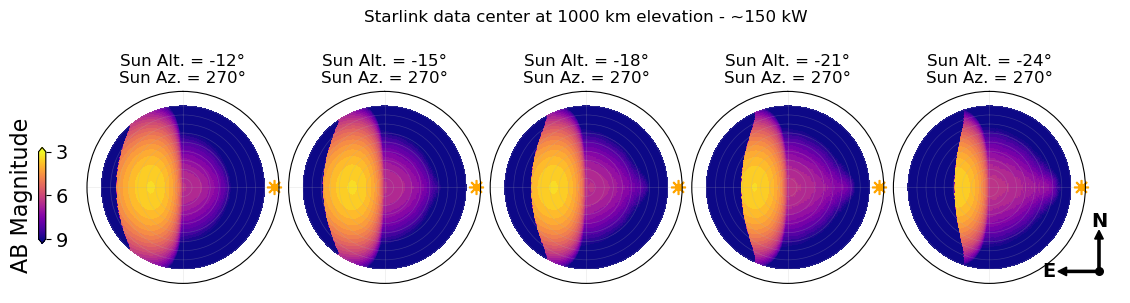

7.772605635930504
7.843200644095375
7.911859175663795
8.01030238792521
8.162263596956242


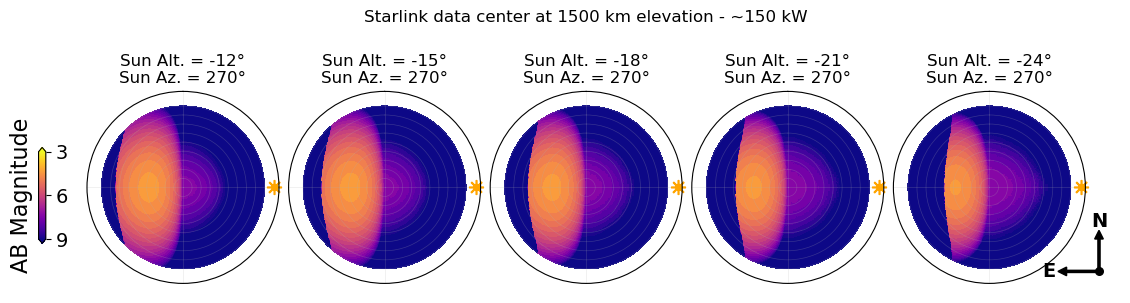

8.206241540558025
8.289609022157068
8.375151612177099
8.467225510066068
8.571802139224788


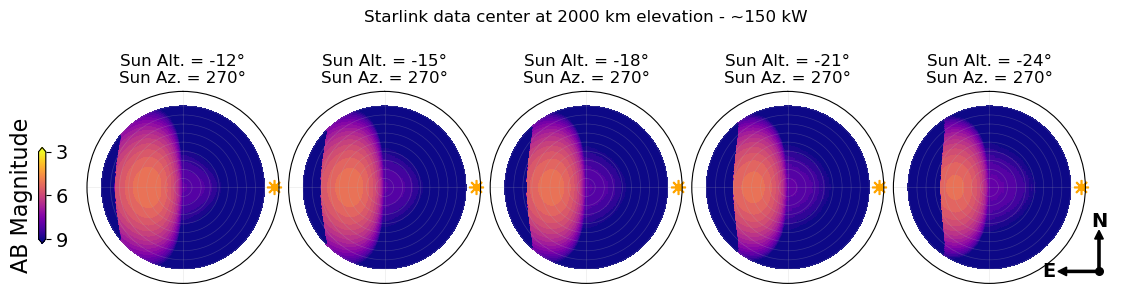

Using interpolated chassis

Generating plots for ~175 kW (Area: 734.72 m²)
5.924106251945425
6.07451955396353
6.500058782081281
7.638611215143709
10.555252832861656


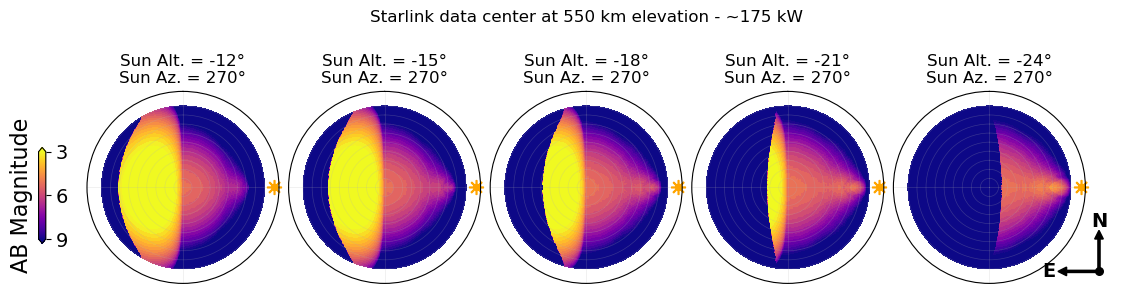

7.039184606049789
7.076435152015407
7.178592554369429
7.384739068418466
7.768919202758516


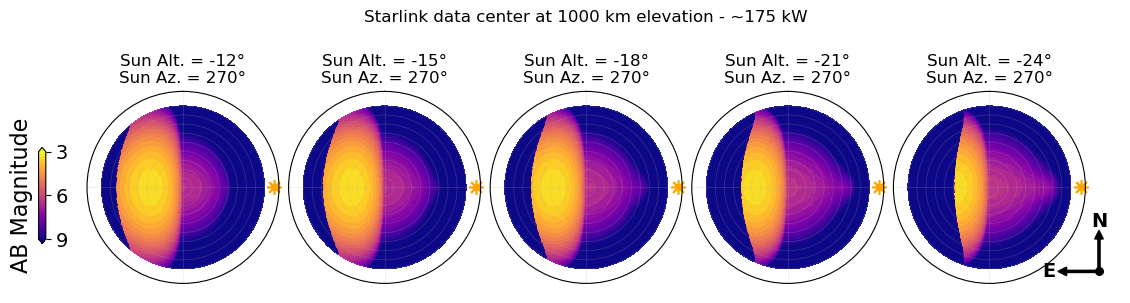

7.706798370600732
7.780631677816415
7.853197307064846
7.956554287208396
8.11467780407585


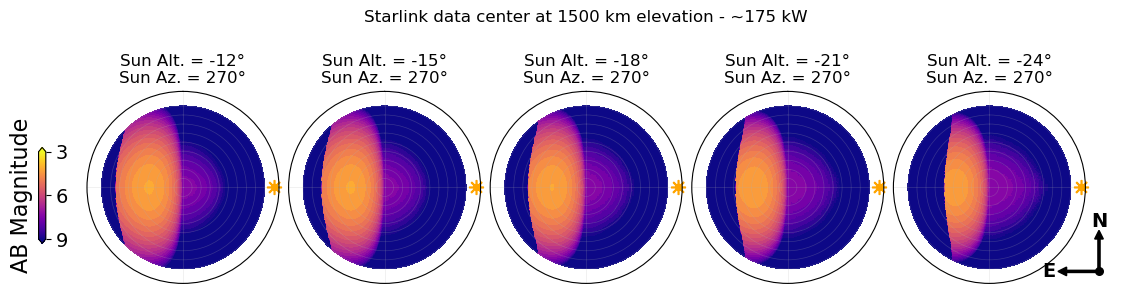

8.141223382023274
8.227637699490641
8.316725248849076
8.413027704469123
8.522605989163047


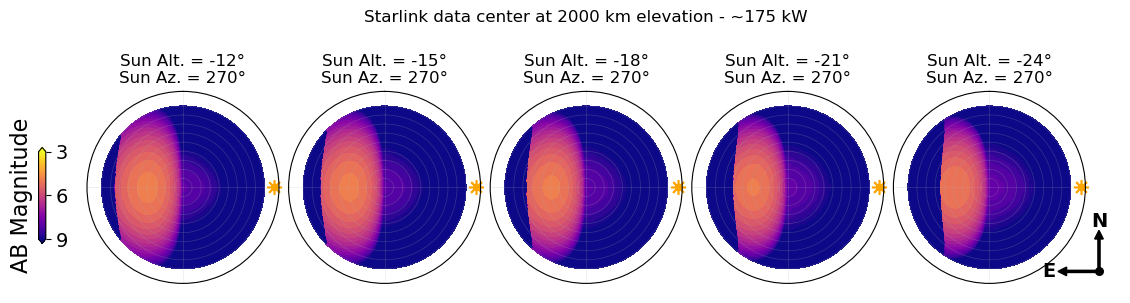

Using interpolated chassis

Generating plots for ~200 kW (Area: 839.68 m²)
5.866629811274963
6.022167739336315
6.4565860191373075
7.613779034598671
10.555252832861656


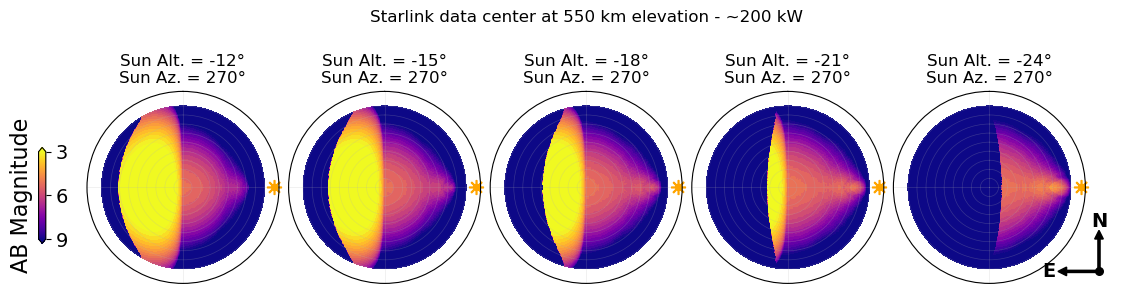

6.981057047418438
7.021569996581831
7.128055448549319
7.340191316836588
7.7331657122994635


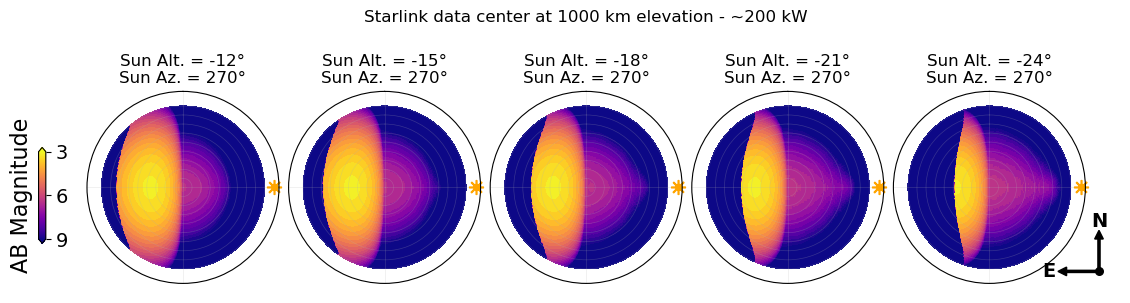

7.649054132520395
7.725673763072037
7.801606842705699
7.909206231385766
8.072660246252209


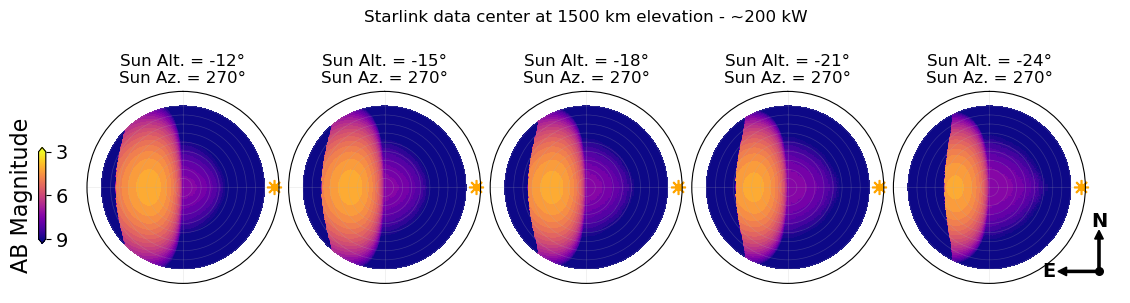

8.084103322644832
8.173136965360163
8.265276483269261
8.365224463383429
8.479122722435706


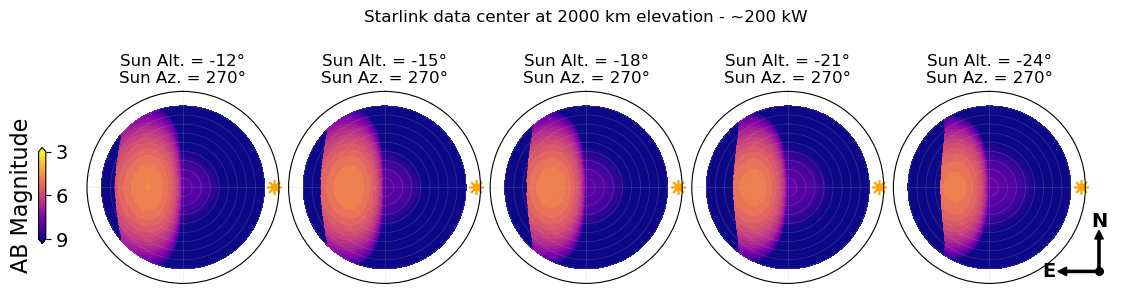

In [9]:
sat_height = [550.0, 1000, 1500, 2000] # in Km

print("This is for instantaneous power output of solar panel from ~100 - 200 kW")

# Loop through each solar array configuration
for area, power_label in solar_array_configs:
    # Set up the satellite model surfaces with current solar array area
    surfaces = satellitemodels.get_surfaces()
    solar_array_surface = Surface(area, [0, 1, 0], lab_solar_array_brdf)
    surfaces.append(solar_array_surface)
    
    print(f"\nGenerating plots for {power_label} (Area: {area:.2f} m²)")
    
    # Generate plots for each satellite height
    for h in sat_height:
        brightness_summary_observer_frame(
            h * 1000,
            [-12, -15, -18, -21, -24],
            [270., 270., 270., 270., 270.],
            levels=(3, 9),
            include_sun=True,
            include_earthshine=False,
            name=f"Starlink data center at {h:.0f} km elevation - {power_label}"
        )

This is for continuous power output of solar panel from 100 - 200 kW meanas the power input doesn't include battery recharging power
Using interpolated chassis

Generating plots for ~100 kW (Area: 839.68 m²)
5.866629811274963
6.022167739336315
6.4565860191373075
7.613779034598671
10.555252832861656


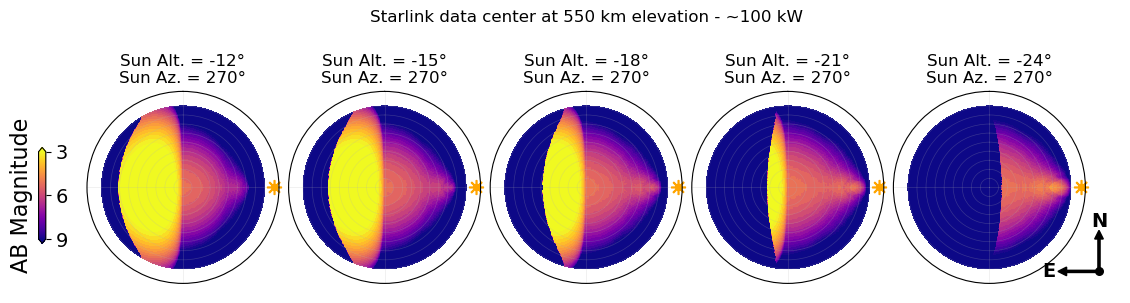

6.981057047418438
7.021569996581831
7.128055448549319
7.340191316836588
7.7331657122994635


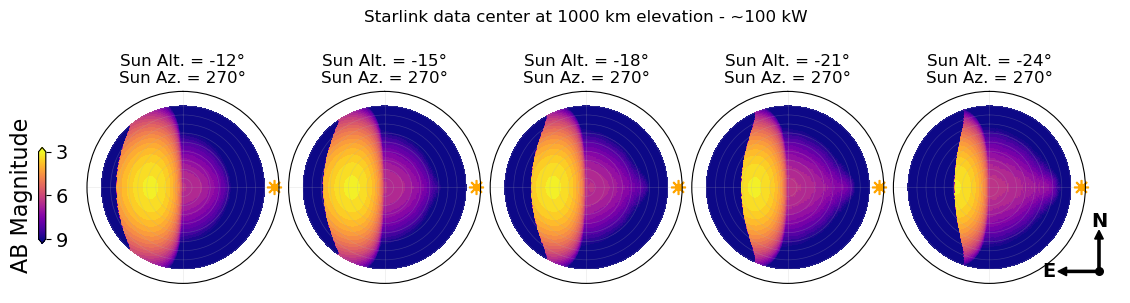

7.649054132520395
7.725673763072037
7.801606842705699
7.909206231385766
8.072660246252209


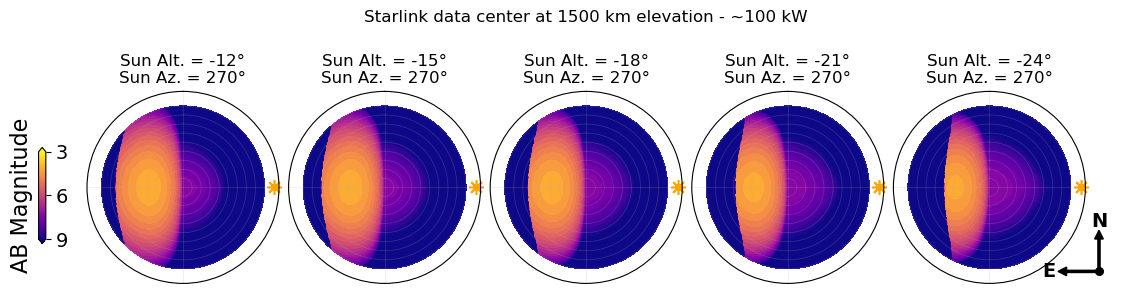

8.084103322644832
8.173136965360163
8.265276483269261
8.365224463383429
8.479122722435706


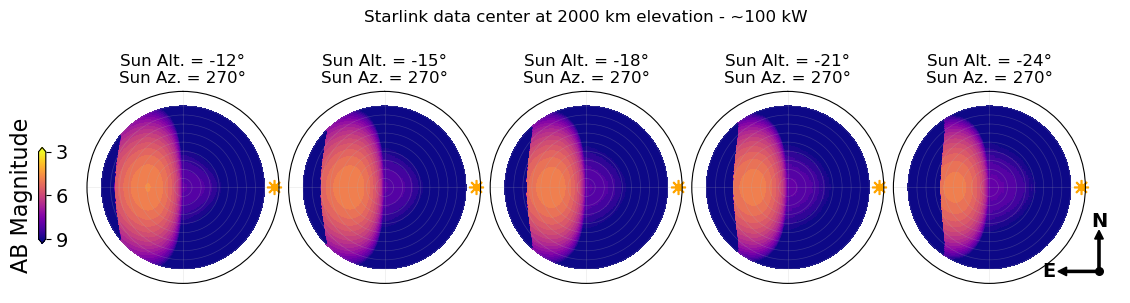

Using interpolated chassis

Generating plots for ~125 kW (Area: 1049.60 m²)
5.769416216753516
5.933490554328535
6.382744075979255
7.571206414283502
10.555252832861656


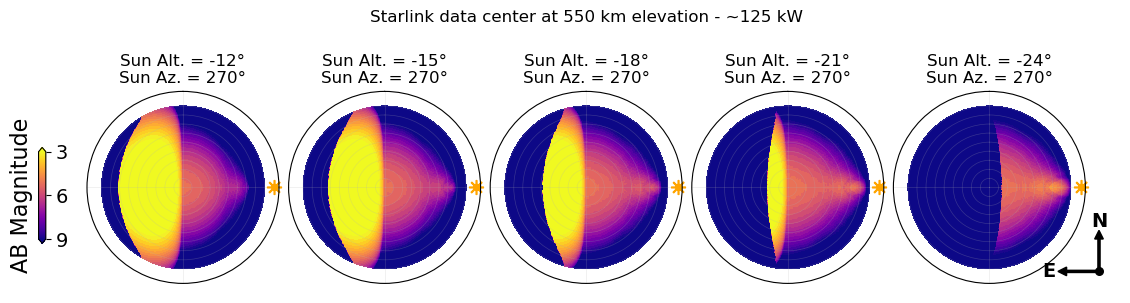

6.882643704368398
6.928573912345553
7.042263918147678
7.264391219653324
7.672078699605734


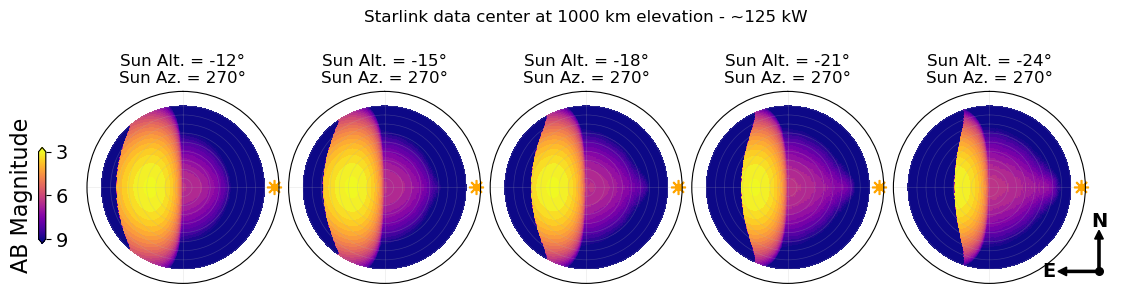

7.551164455227084
7.632403586873183
7.713929277838463
7.828587287283413
8.000928187393274


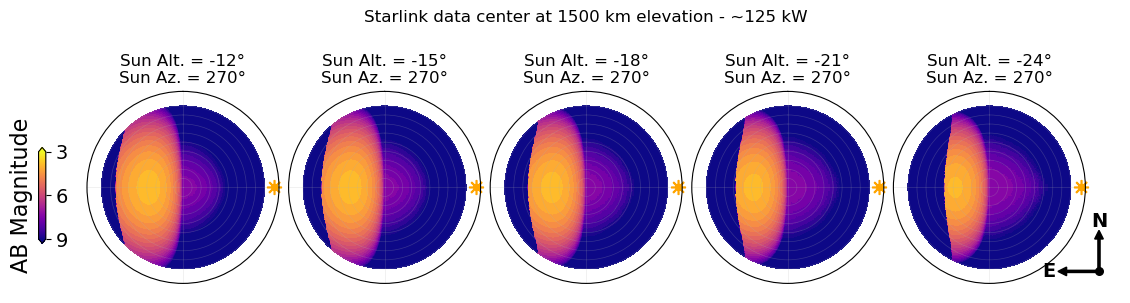

7.987144224892231
8.080515810608384
8.17771708170874
8.283719470415612
8.404806064009959


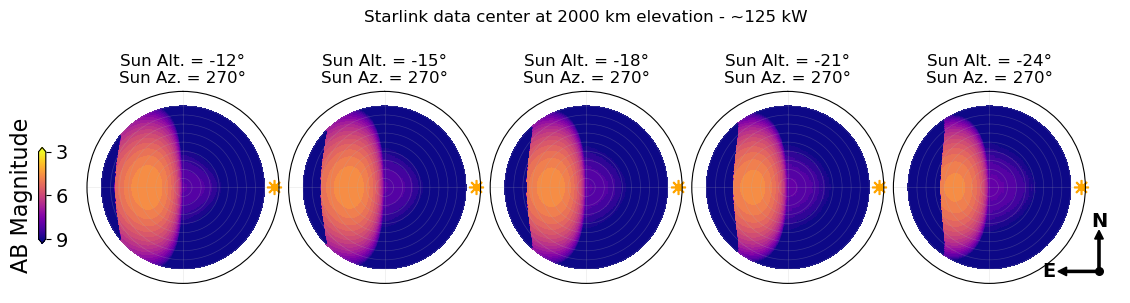

Using interpolated chassis

Generating plots for ~150 kW (Area: 1259.52 m²)
5.689009974421862
5.860035258177839
6.321404885584678
7.535505673856903
10.555252832861656


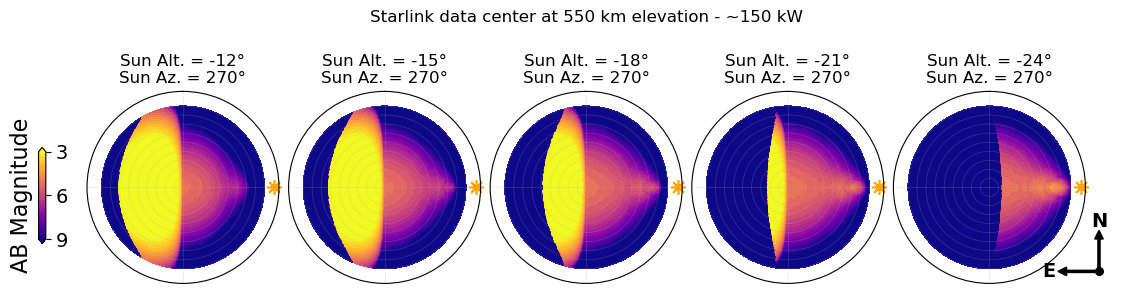

6.8011643190847435
6.851490928048496
6.971042007370244
7.201314571727346
7.621031058044332


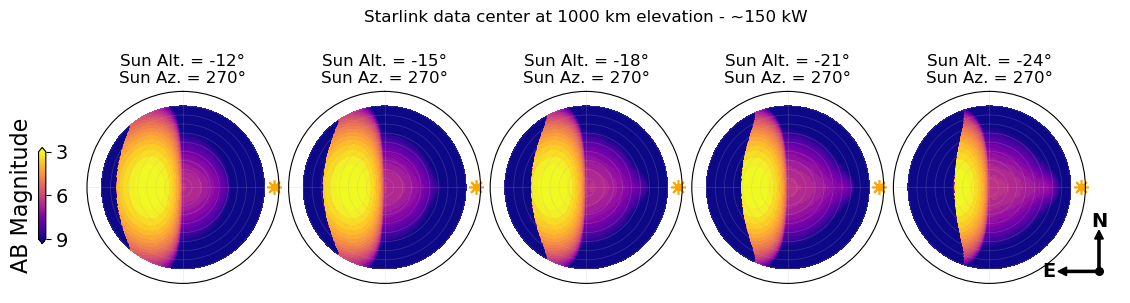

7.4700148235625985
7.554996753472197
7.641060758804648
7.761456748429759
7.941035695007134


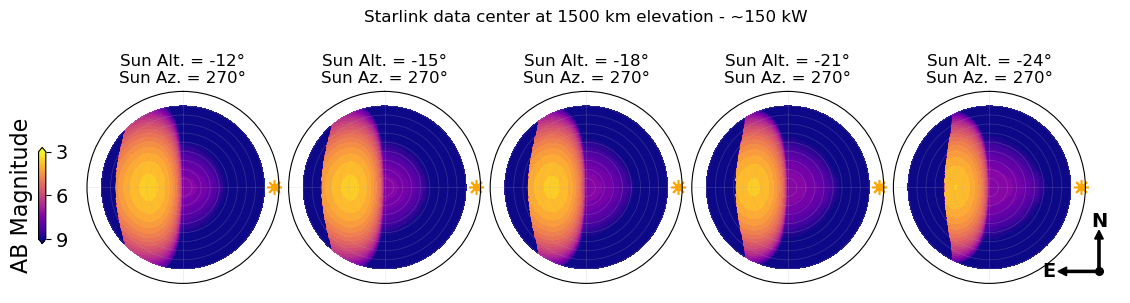

7.906660324014939
8.003542292905133
8.10484485521825
8.21575865195849
8.342687030019444


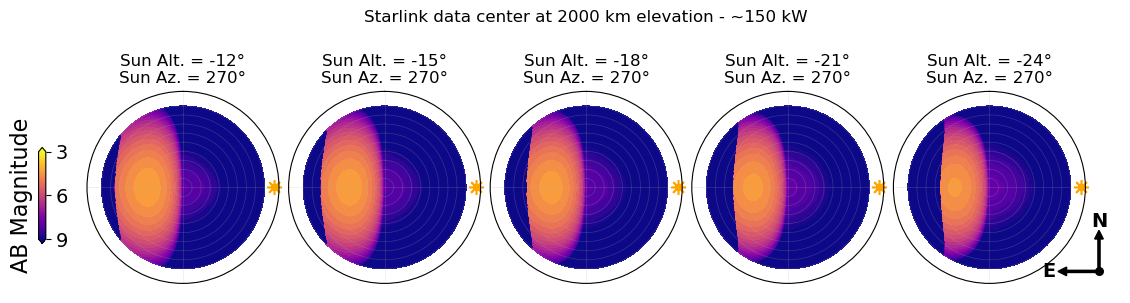

Using interpolated chassis

Generating plots for ~175 kW (Area: 1469.44 m²)
5.620413185028377
5.797299986475741
6.268908545974089
7.5047363136759895
10.555252832861656


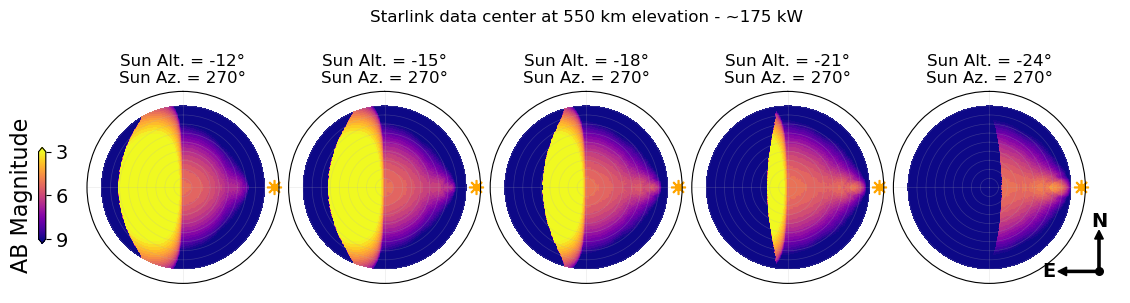

6.7316023412386174
6.78562683171098
6.9101161847685875
7.147261633321954
7.577149064402474


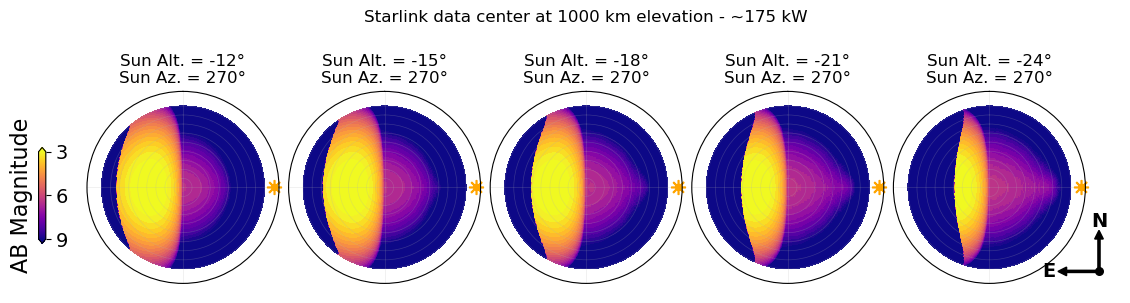

7.400669925782334
7.48879607180405
7.578676327938309
7.703903168834004
7.889583838328812


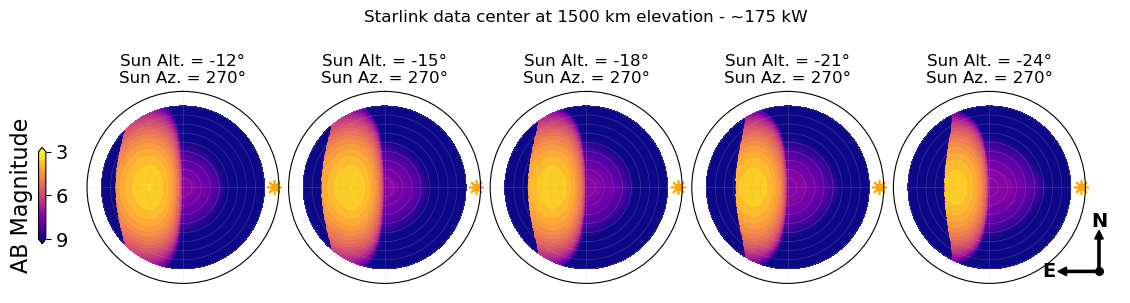

7.837818708724429
7.937646722212295
8.042393863266723
8.157435592830703
8.289279763263897


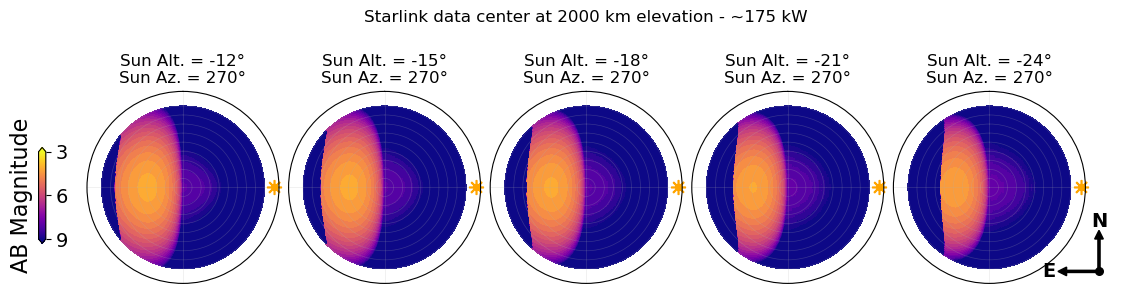

Using interpolated chassis

Generating plots for ~200 kW (Area: 1679.36 m²)
5.560577959366986
5.742531651771141
6.2230052079947376
7.477684126167087
10.555252832861656


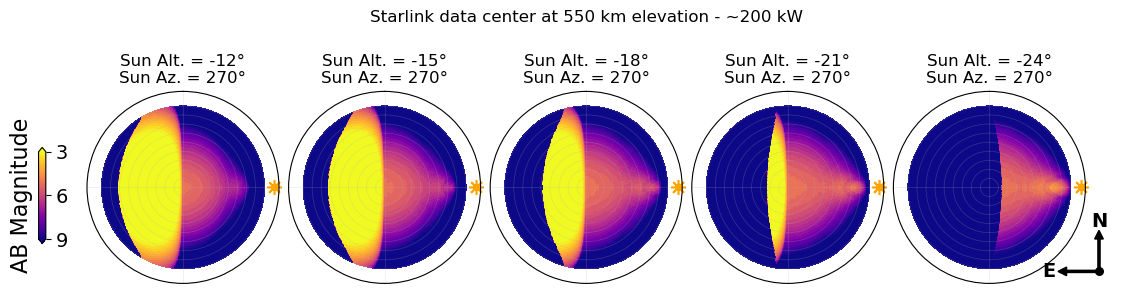

6.670892358055466
6.728106923872736
6.856861817457792
7.099950299219954
7.538646374370441


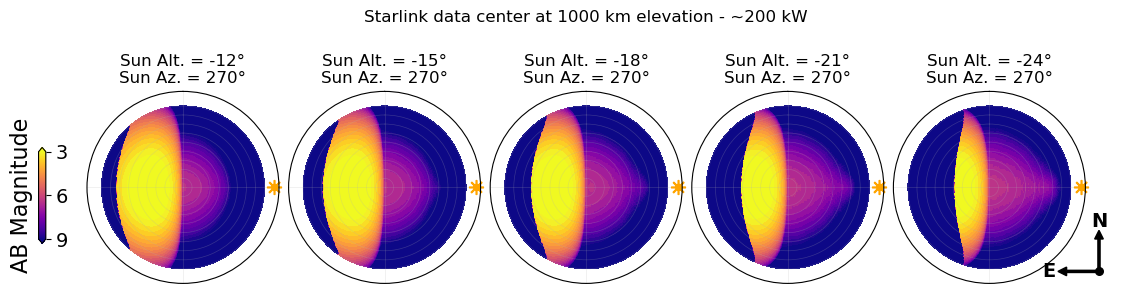

7.340106374558699
7.430942346097797
7.524113713868113
7.653510298245579
7.84446258167155


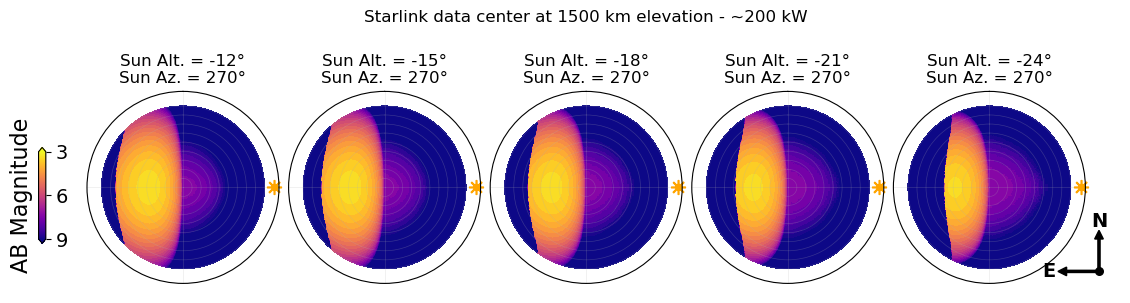

7.777650949431895
7.880015898877373
7.987730680336258
8.106330393211975
8.242415183759563


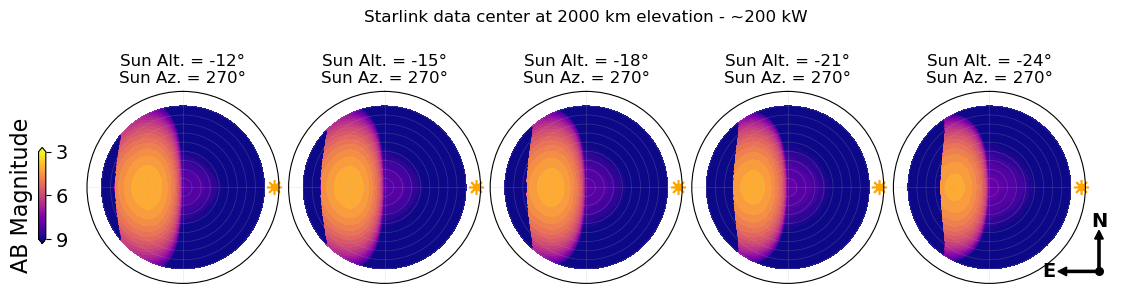

In [10]:
# Define solar array areas and their power equivalents
solar_array_configs_continuous = [
    (104.96 * 8, "~100 kW"),
    (104.96 * 10, "~125 kW"),
    (104.96 * 12, "~150 kW"),
    (104.96 * 14, "~175 kW"),
    (104.96 * 16, "~200 kW")
]

print("This is for continuous power output of solar panel from 100 - 200 kW meanas the power input doesn't include battery recharging power")

sat_height = [550.0, 1000, 1500, 2000] # in Km

# Loop through each solar array configuration
for area, power_label in solar_array_configs_continuous:
    # Set up the satellite model surfaces with current solar array area
    surfaces = satellitemodels.get_surfaces()
    solar_array_surface = Surface(area, [0, 1, 0], lab_solar_array_brdf)
    surfaces.append(solar_array_surface)
    
    print(f"\nGenerating plots for {power_label} (Area: {area:.2f} m²)")
    
    # Generate plots for each satellite height
    for h in sat_height:
        brightness_summary_observer_frame(
            h * 1000,
            [-12, -15, -18, -21, -24],
            [270., 270., 270., 270., 270.],
            levels=(3, 9),
            include_sun=True,
            include_earthshine=False,
            name=f"Starlink data center at {h:.0f} km elevation - {power_label}"
        )